<center>

# Trabajo Práctico 2: EXTRACCIÓN DE CARACTERÍASTICAS

## Procesamiento Avanzado de Imágenes en Biomedicina y Biología

### Segundo Cuatrimestre 2024

<table>
      <tr>
        <th>Alumnos</th>
        <th>Legajos</th>
      </tr>
      <tr>
        <td>
          Bajlec, Ivo<br>
          Grau, Gonzalo Andrés<br>
          Neira, Lucas Matias
        </td>
        <td>
          62175<br>
          62259<br>
          61750<br>
        </td>
      </tr>
    </table>

**Docente**: Roberto Sebastián Tomás

**Fecha de entrega**: 07/09/2024

</center>

In [1]:
# Imports necesarios para el resto del archivo
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from skimage.transform import hough_circle
import ipywidgets as widgets
from IPython.display import display
from descrip_fourier_hu import *
from texturas import *
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

###  2- Analice y compare las imágenes img-1, img-2 e img-5contenidas en la carpeta: “PAIByB-4”


In [15]:
lista_paths = lista_de_paths(path_folder= 'PIByB_4')
lista_imagenes = []
for i in lista_paths:
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    lista_imagenes.append(image)\
    


#### 2.1. Elija un contorno a analizar y compara los descriptores de forma de fourier y los momentos Hu. ¿Qué puede concluir de esta comparación?¿Cual de los métodos le resulto mejor para la extracción de características?

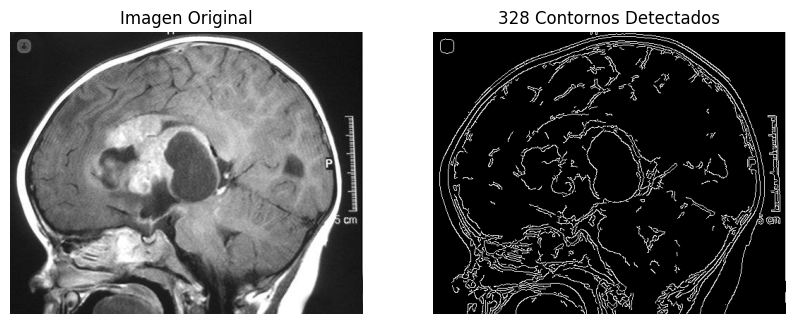

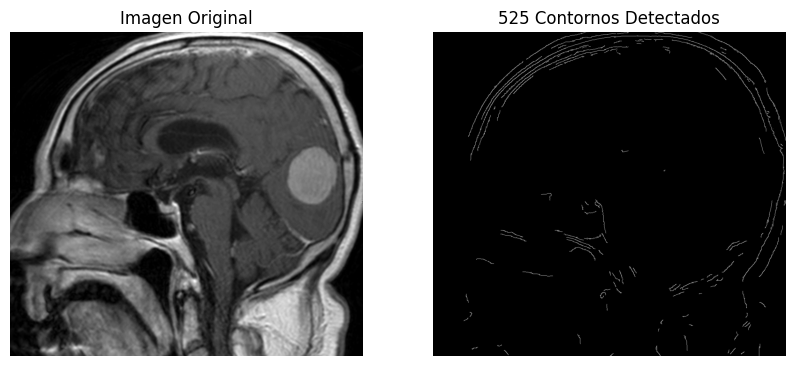

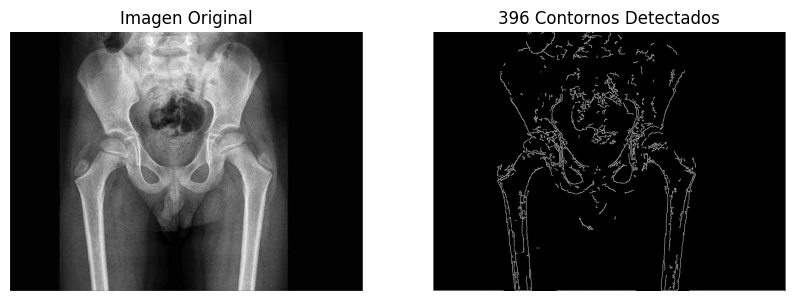

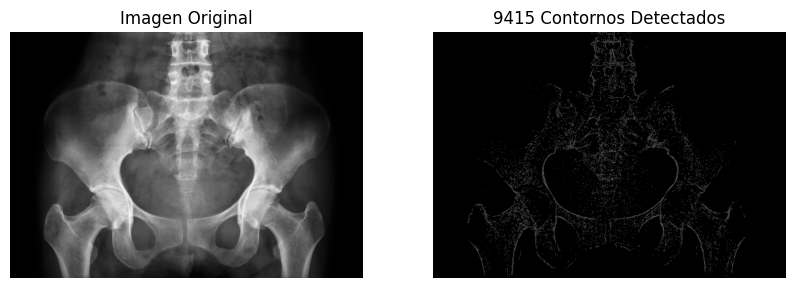

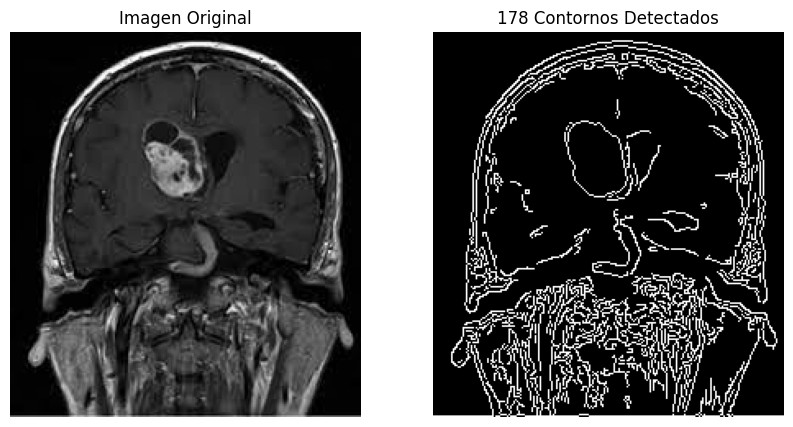

In [41]:
lista_max_contorno = []

for i in range (len(lista_imagenes)):
    if i == 1:
       contornos = Contornos(lista_imagenes[i],plot=True,upper_tresh=150,lower_tresh= 75)
    elif i == 3:
       contornos = Contornos(lista_imagenes[i],plot=True,upper_tresh=130,lower_tresh= 75,otsu= True)
    else :   
        contornos = Contornos(lista_imagenes[i],plot=True)
        #se agrega el contorno de mayor area cubierta, el mas grande 
    lista_max_contorno.append(max(contornos, key=cv2.contourArea))
    

para la imagen img-4.tif, se ve como ni siquiera usando una binarizacion por otsu que arroja un numero exorbitante de contornos, todos son muy diminutos

##### Imagen orignal y su contorno maximo


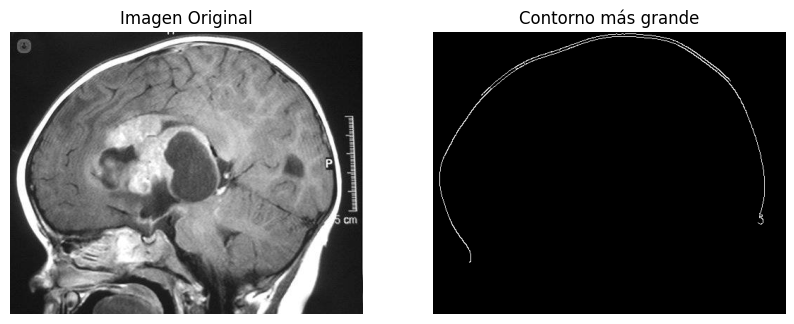

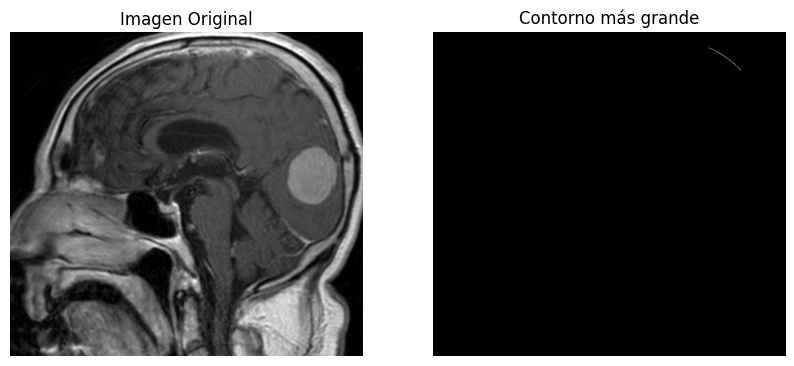

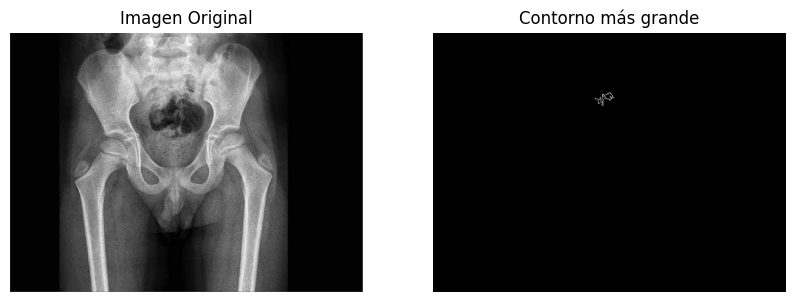

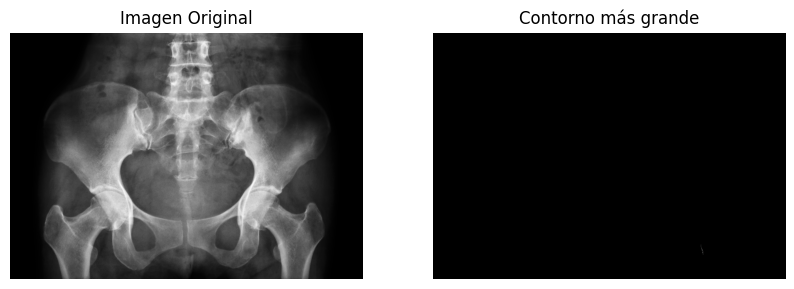

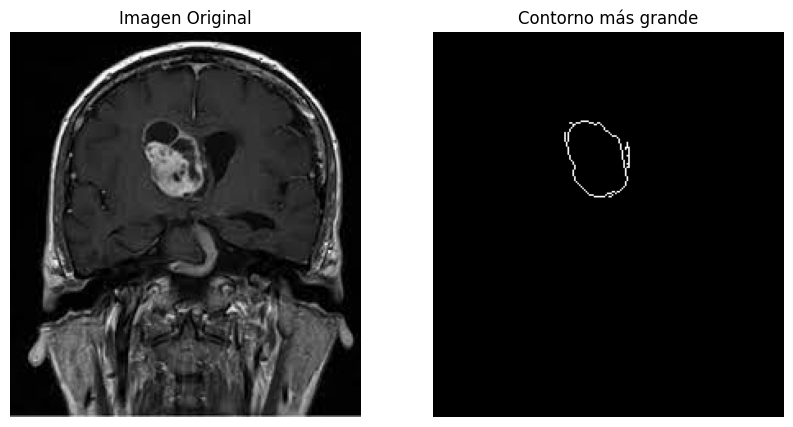

In [40]:
for j in range(len(lista_imagenes)):
    
    imagen_contornos = np.zeros_like(lista_imagenes[j])  # Imagen negra para dibujar los contornos
    # Dibuja el contorno más grande en una imagen vacía
    cv2.drawContours(imagen_contornos, [lista_max_contorno[j]], -1, 255, 1)  # 1 píxel de grosor, color blanco

    # Mostrar la imagen original y la imagen con los contornos
    plt.figure(figsize=(10, 5))
    
    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(lista_imagenes[j], cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen con el contorno más grande
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_contornos, cmap='gray')
    plt.title('Contorno más grande')
    plt.axis('off')

    # Mostrar el gráfico
    plt.show()

### Momentos de Hu

#### Se presentan los momentos de Hu para cada contorno maximo, en escala logaritmica 

In [46]:
# Inicializa una lista para almacenar los datos de cada imagen
datos_moments = []

# Recorre cada contorno y almacena los momentos de Hu en la lista
for k in range(len(lista_max_contorno)):
    dic = Hu_moments(contorno=lista_max_contorno[k], label=k + 1)
    
    # Extrae el label y los momentos de Hu
    label = dic['label']
    hu_values = dic['Hu_Moments']

    # Crea un diccionario para la fila del DataFrame
    fila = {'Imagen': label}
    # Agrega los momentos de Hu al diccionario
    fila.update(hu_values)

    # Agrega la fila al listado de datos
    datos_moments.append(fila)

# Crea el DataFrame de pandas
df_moments = pd.DataFrame(datos_moments)

# Asegúrate de que las columnas del DataFrame estén en el orden correcto
# Las columnas se agregarán automáticamente, pero aquí las enumeramos
df_moments = df_moments[['Imagen'] + [f'Hu_Moment_{i+1}' for i in range(7)]]

# Muestra el DataFrame
print(df_moments)

   Imagen  Hu_Moment_1  Hu_Moment_2  Hu_Moment_3  Hu_Moment_4  Hu_Moment_5  \
0       1    -1.769835    -3.194120    -4.920004    -4.853258    -9.445185   
1       2    -1.396253    -2.786694    -2.755729    -2.283181    -4.740766   
2       3     0.210040     0.724523     1.201143     0.908553     1.969334   
3       4     0.146349     0.375539     0.690021     0.750352     1.470543   
4       5     0.758825     2.361965     4.315824     5.768248    10.905516   

   Hu_Moment_6  Hu_Moment_7  
0    -6.163566     9.675270  
1    -3.378781    -4.499798  
2     1.289860     2.748085  
3     0.971093     3.779938  
4     7.090303    11.035148  


### Descriptores de Fourier 

#### se calcula la FFT del contorno y se eliminan las frecuencias intermedias 

In [56]:
list_filt_contornos = []
list_fourier_contor = []
list_fourier_contor_filt = []


for t in lista_max_contorno:
    # mantengo solo el 20% mas bajo y el 20% mas alto 
    contorno_fourier_filt, contorno_fourier = contorno2fourier(borde= t, porcentaje_descriptores= 0.2)

    list_fourier_contor.append(contorno_fourier)
    list_fourier_contor_filt.append(contorno_fourier_filt)

    contorno_recon = reconstruir_contorno(contorno_fourier = contorno_fourier,shift= True)
    list_filt_contornos.append(contorno_recon)


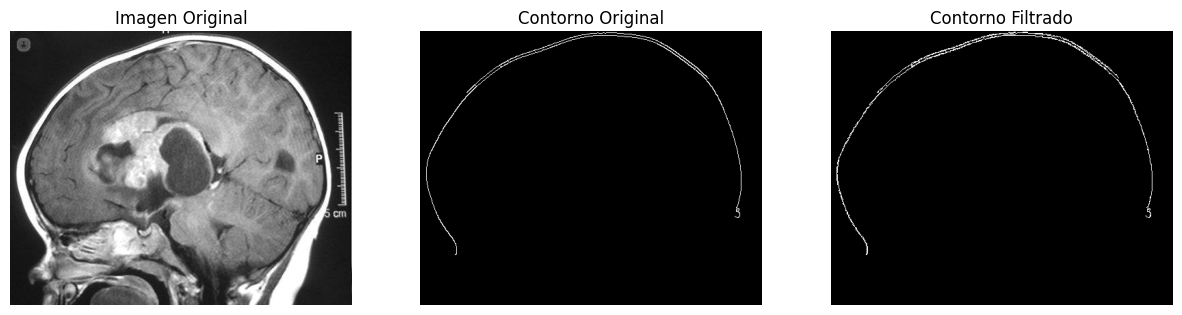

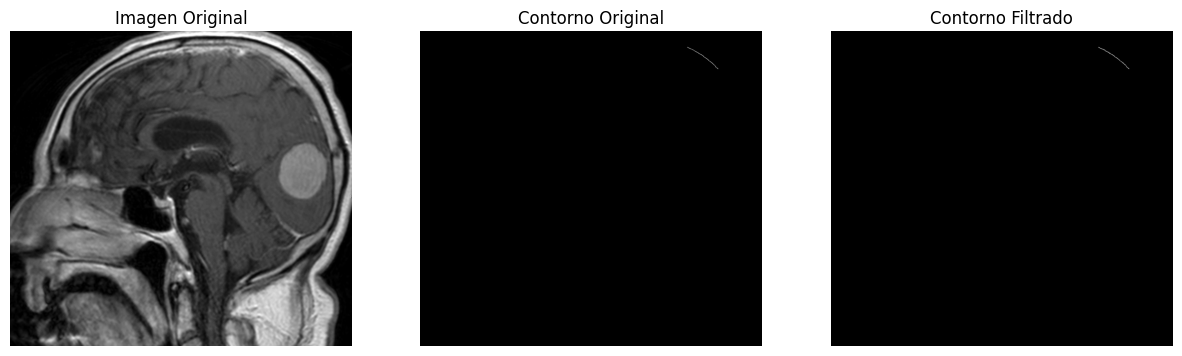

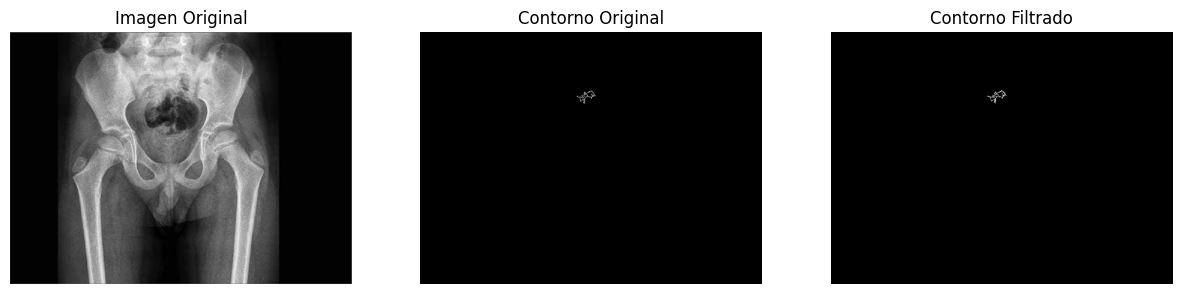

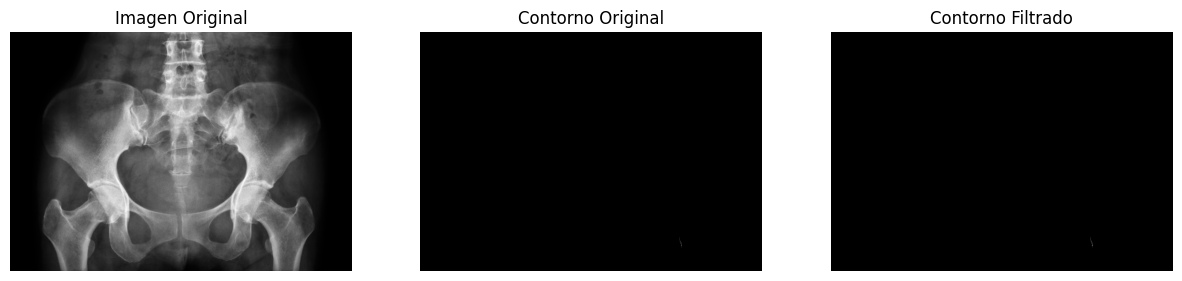

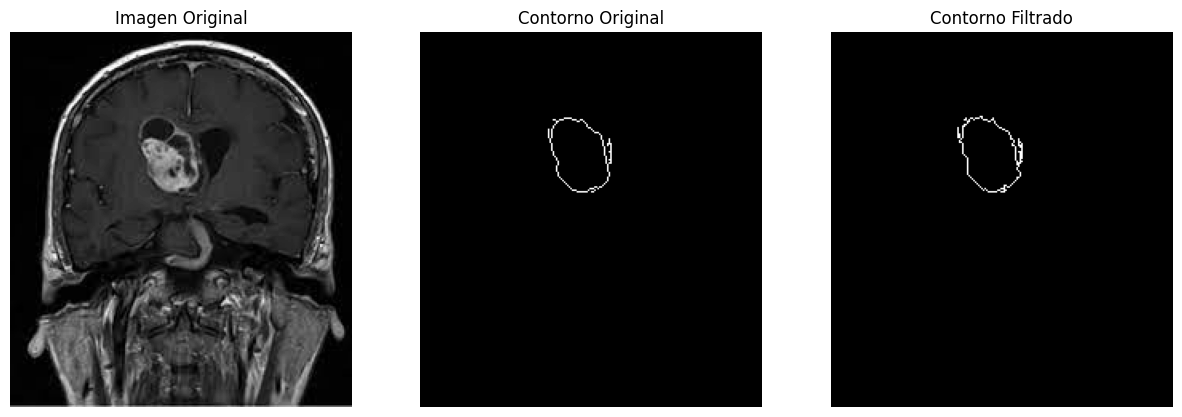

In [70]:
for j in range(len(lista_max_contorno)):
    # Crear la imagen negra para dibujar el contorno original
    imagen_contornos = np.zeros_like(lista_imagenes[j])  
    cv2.drawContours(imagen_contornos, [lista_max_contorno[j]], -1, 255, 1)  # Dibuja el contorno original

    # Crear la imagen negra para dibujar el contorno filtrado
    imagen_contornos_filt = np.zeros_like(lista_imagenes[j])
    cv2.drawContours(imagen_contornos_filt, [list_filt_contornos[j]], -1, 255, 1)  # Dibuja el contorno filtrado

    # Crear un nuevo gráfico para cada imagen
    plt.figure(figsize=(15, 5))  # Ancho mayor para acomodar las tres imágenes

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(lista_imagenes[j], cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen con el contorno original
    plt.subplot(1, 3, 2)
    plt.imshow(imagen_contornos, cmap='gray')
    plt.title('Contorno Original')
    plt.axis('off')

    # Imagen con el contorno filtrado
    plt.subplot(1, 3, 3)
    plt.imshow(imagen_contornos_filt, cmap='gray')
    plt.title('Contorno Filtrado')
    plt.axis('off')

    # Mostrar el gráfico
    plt.show()

### Conclusion:
Los momentos de Hu son utiles para brindar caracteristicas que son invariantes a las transformaciones. A su vez al ser solamente 7 por imagen son facilmente comparables. 
La transformada de fourier nos va a brindar una caracterización mucho mas minusiosa al poder apreciar el espctro de frecuencias, sin embargo es dificil de interpretar por el amplio rango que puede llegar a haber de estas. Ademas, no es invariante a transformaciones, para lograrloshay que seguir una serie de pasos: 

- Invarianza a traslación: Ignorar la frecuencia cero .
- Invarianza a rotación: Usar solo las magnitudes de los coeficientes de Fourier.
- Invarianza a escala: Normalizar los coeficientes dividiéndolos por la magnitud del primer coeficiente.

Sin embargo, luego de realizarlo los resultados no fueron prometedores, por lo cual se concluye que Hu tiene menos capacidad de información, pero la compensa en invarianza,

### 2.2 Analice las texturas del contorno elegido mediante filtros Gabor, transformada de Fuorier y transformada wavelet. ¿Puede caracterizar de forma única la textura de los objeto mediante los métodos utilizados?¿Qué puede decir de los valores obtenidos para cada imagen? 

## 3- Compara los métodos de obtención de puntos de interés: SIFT y ORB, de los imágenes contenidas en la carpeta “PAIByB-4”. ¿Que puede decir de cada método? ¿Cuál le resultó más eficiente?
Para realizar este análisis, utilizaremos el módulo `time` para cronometrar el rendimiento

In [5]:
def evaluate_keypoint_method(base_dir: str,
                             feature_obj: cv2.Feature2D,
                             obj_name: str) -> float:
   """
   Go through all images in a directory, exteact keypoint features, time the process
   :param base_dir: where to find the images   
   :param feature_obj: object used to extract 2D features 
   :param obj_name: identifyer for the object 
   :return: time elapsed
   """
   start = time.time()
   for image in os.listdir('PIByB_4'):
      raw_img = cv2.imread(f'{base_dir}/{image}') 
      keypoints, descriptors = feature_obj.detectAndCompute(raw_img, None)
      img_sift = cv2.drawKeypoints(raw_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      plt.title(f'SIFT features for {image}')
      plt.imshow(img_sift)
      plt.axis('off')
      plt.show()

   end = time.time()
   time_elapsed = end - start
   print(f"Time elapsed for {obj_name} is {time_elapsed:.3f} seconds")   
   return time_elapsed  

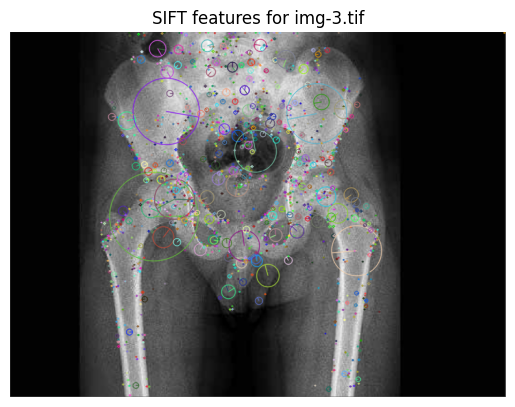

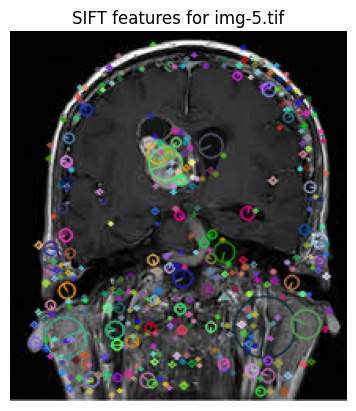

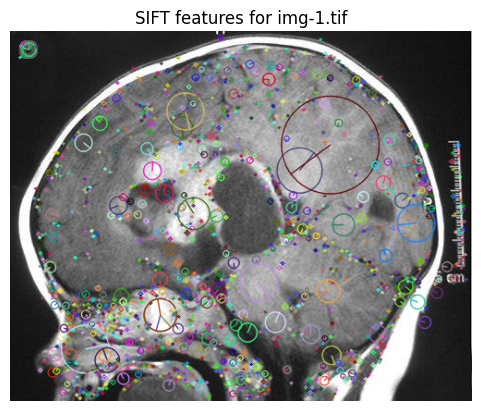

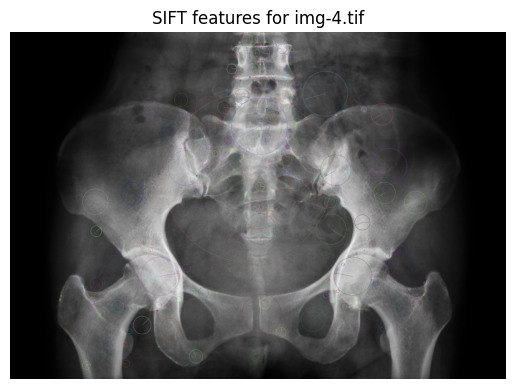

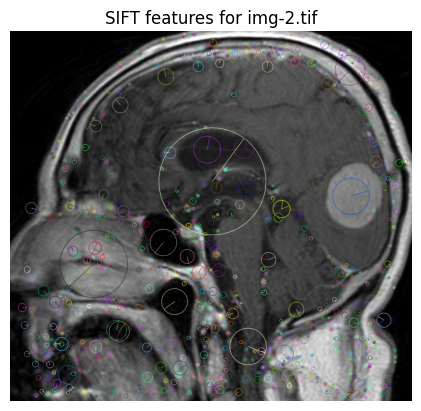

Time elapsed for SIFT is 7.046 seconds


In [6]:
sift = cv2.SIFT_create()
base_dir = 'PIByB_4'
sift_time = evaluate_keypoint_method(base_dir, sift, 'SIFT')

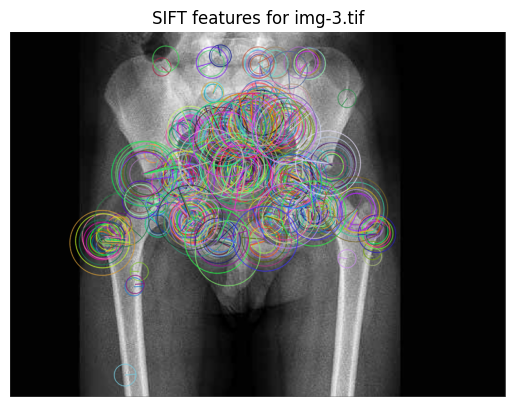

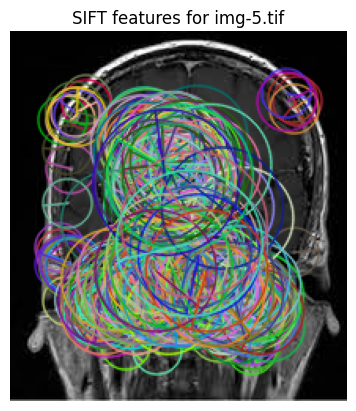

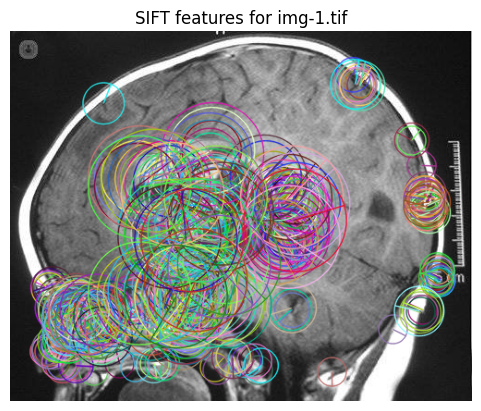

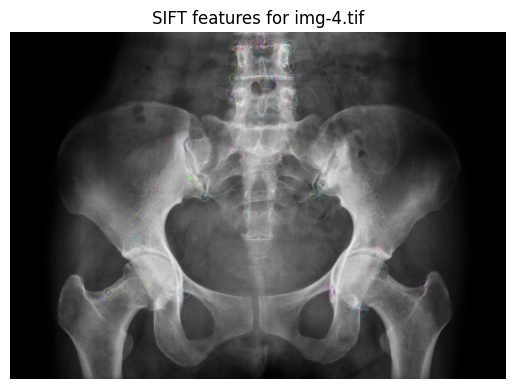

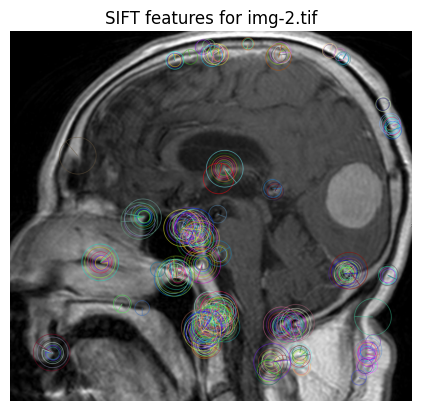

Time elapsed for ORB is 2.454 seconds


In [7]:
orb = cv2.ORB_create()  
orb_time = evaluate_keypoint_method(base_dir, orb, 'ORB')

In [9]:
print(f'ORB is {sift_time/orb_time:.2f} times faster than SIFT')  

ORB is 2.87 times faster than SIFT


## 4- Analice las lineas rectas de las imágenes img-3 e img-4 contenidas en la carpeta “PAIByB-4” mediante transformada Hough y luego aplique detectores de Harris. Visualice los resultados sobre las imágenes originales con diferentes colores ¿Qué puede observar?

Como primer paso, vamos a determianr los límites del filtro Canny

In [11]:
img_paths = ['PIByB_4/img-4.tif', 'PIByB_4/img-3.tif']

# Function to apply Canny edge detection and plot the result
def apply_canny(low_threshold, high_threshold, raw_img):
    edges = cv2.Canny(raw_img, low_threshold, high_threshold)
    plt.figure(figsize=(6,6))
    plt.imshow(edges, cmap='gray')
    plt.title(f'Canny Edge Detection (low: {low_threshold}, high: {high_threshold})')
    plt.axis('off')
    plt.show()

In [18]:
for img_path in img_paths:
    # Create interactive sliders for the thresholds
    low_thresh_slider = widgets.IntSlider(value=50, min=0, max=255, step=1, description="Low Threshold")
    high_thresh_slider = widgets.IntSlider(value=150, min=0, max=255, step=1, description="High Threshold")
    ui = widgets.VBox([low_thresh_slider, high_thresh_slider])
    raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    output = widgets.interactive_output(apply_canny, {'low_threshold': low_thresh_slider, 
                                                      'high_threshold': high_thresh_slider,
                                                      'raw_img': widgets.fixed(raw_img)})   
    display(ui, output)

Output()

Output()

A partir de esto, analizamos los espacios de Hough

Hough Line detection for PIByB_4/img-4.tif...
Hough Circle detection for PIByB_4/img-4.tif...


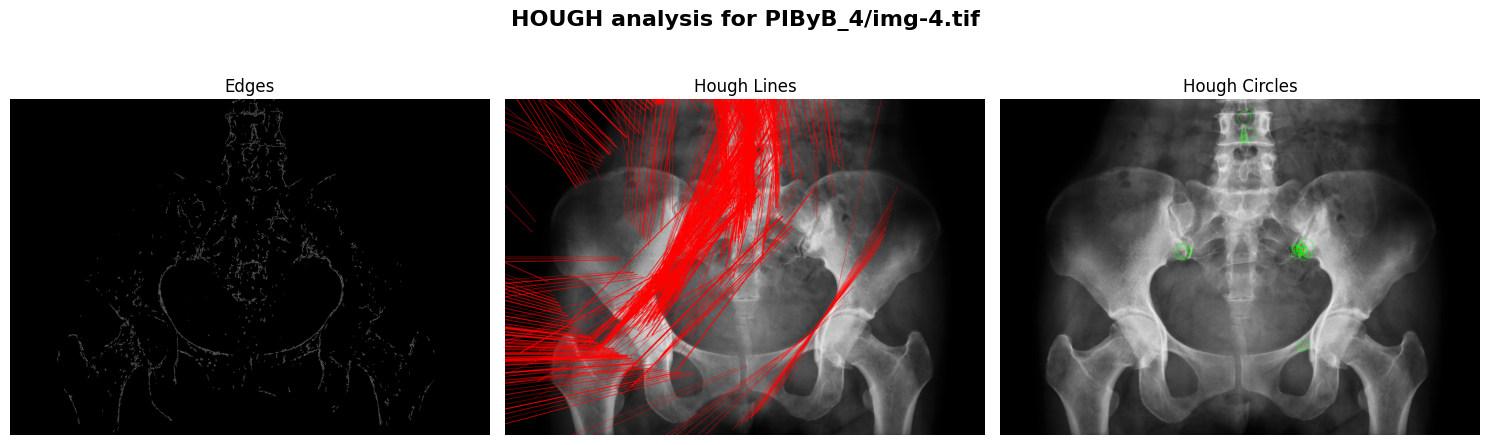

Hough Line detection for PIByB_4/img-3.tif...
Hough Circle detection for PIByB_4/img-3.tif...


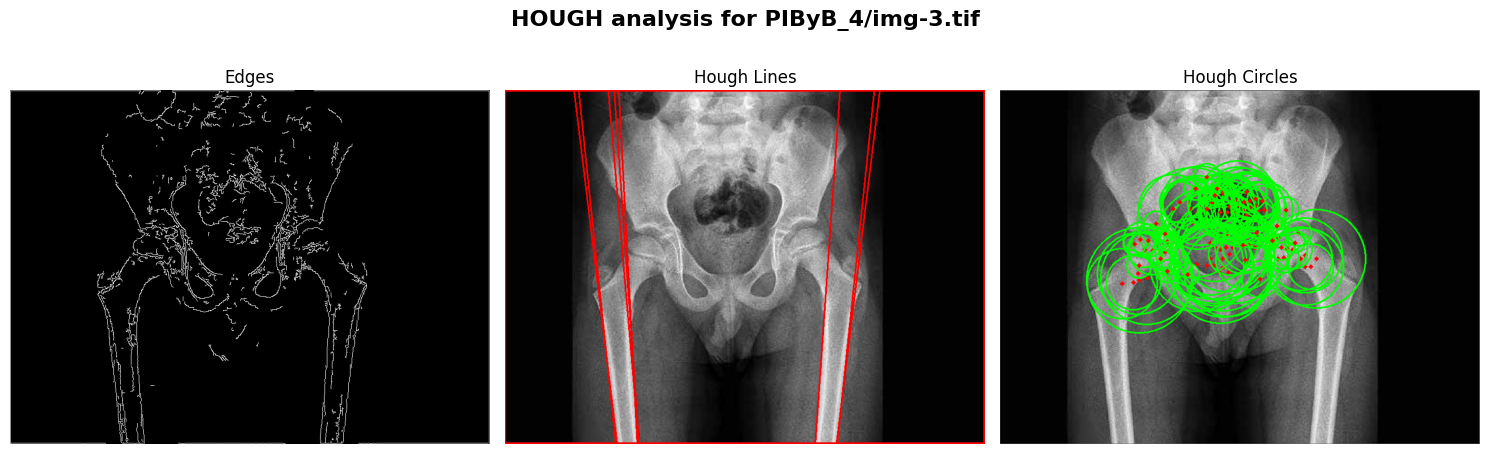

In [7]:
img_paths = ['PIByB_4/img-4.tif', 'PIByB_4/img-3.tif']
threshold_pairs = [(30, 100), (100, 200)]
for img_path, thresholds in zip(img_paths, threshold_pairs):
    raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(raw_img, *thresholds)
    
    # Hough Line detection
    print(f"Hough Line detection for {img_path}...")
    hough_lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    img_with_lines = cv2.cvtColor(raw_img, cv2.COLOR_GRAY2BGR)
    
    if hough_lines is not None:
        for line in hough_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Hough Circle detection
    print(f"Hough Circle detection for {img_path}...")
    hough_circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 10, param1=50, param2=30, minRadius=5, maxRadius=100)
    img_with_circles = cv2.cvtColor(raw_img, cv2.COLOR_GRAY2BGR)
    
    if hough_circles is not None:
        hough_circles = np.uint16(np.around(hough_circles))
        for circle in hough_circles[0, :]:
            center = (circle[0], circle[1])  # center coordinates
            radius = circle[2]  # radius of the circle
            cv2.circle(img_with_circles, center, radius, (0, 255, 0), 2)
            cv2.circle(img_with_circles, center, 2, (0, 0, 255), 3)
    
    # Plotting the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(edges, cmap='gray')
    axs[0].set_title('Edges')
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title('Hough Lines')
    
    axs[2].imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))
    axs[2].axis('off')
    axs[2].set_title('Hough Circles')
    
    fig.suptitle(f'HOUGH analysis for {img_path}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()


Finalmente, analizamos los puntos de esquina de Harris

In [14]:
def harris_corner_detection(image, block_size=2, ksize=3, k=0.04):
    """
    Perform Harris corner detection on an image.
    
    :param image: Input image in grayscale
    :param block_size: It is the size of neighbourhood considered for corner detection
    :param ksize: Aperture parameter of the Sobel derivative used
    :param k: Harris detector free parameter in the equation
    :return: Image with corners marked
    """
    # Detect corners
    dst = cv2.cornerHarris(image, block_size, ksize, k)
    
    # Dilate corner image to enhance corner points
    dst = cv2.dilate(dst, None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_with_corners[dst > 0.01 * dst.max()] = [0, 0, 255]

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    plt.title(f'Harris Corners for {img_path}')
    plt.axis('off')
    plt.show()

    return image_with_corners


Para evaluar el funcionamiento de los hiperparametros, utilizamos sliders

In [21]:
for img_path in img_paths:
    # Create interactive sliders for hiperparameters 
    block_size = widgets.IntSlider(value=3, min=1, max=25, step=1, description="Block Size")
    k_value = widgets.FloatSlider(value=0.04, min=0, max=0.1, step=0.01, description="k Value")
    ksize = widgets.IntSlider(value=5, min=1, max=15, step=2, description="Kernel Size")
    ui = widgets.VBox([block_size, k_value, ksize])
    raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    output = widgets.interactive_output(harris_corner_detection, {'image': widgets.fixed(raw_img), 
                                                                 'block_size': block_size, 
                                                                 'ksize': ksize, 
                                                                 'k': k_value}) 
    display(ui, output)

Output()

Output()